# Time series classification

Calculation of the MFCC using CMSIS Digital Signal Processing Library and relative Python Wrapper.

[CMSIS DSP library](https://github.com/STMicroelectronics/STM32CubeU5/tree/main/Drivers/CMSIS/DSP) is made by ARM and it is optimized for its microcontroller cores, including of course STM32 series by STMicroelectronics. The [Python wrapper](https://developer.arm.com/documentation/102463/latest/) for the CMSIS DSP functions allows experimenting with them in a Python notebook. It ensures that processing results will be equivalent when porting an algorithm to a microcontroller and using C.

In [1]:
import sys
sys.path.insert(1, 'vespucci')
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
from pre_processing import *
from ml_support import *


In [2]:
pre_processing_data = pre_processing_init()
CLASSES = ["Slow", "Fast", "Slow with disturbance", "Fast with disturbance"]

<br>
<br>
<br>

## Spectrogram

In [3]:
# The user must choose these parameters
number_of_averages=50

# Load acceleration data
df_ACC_S, df_ACC_F, df_ACC_SD, df_ACC_FD = load_data(resampling_active=True, Resampling_frequency=pre_processing_data.ism330dhcx_odr)

# Spectrum calculation
freq_S, P_spectr_S = signal_welch(df_ACC_S, sensor_Type='A_'+pre_processing_data.axis+' [g]', n_avg = number_of_averages)
freq_F, P_spectr_F = signal_welch(df_ACC_F, sensor_Type='A_'+pre_processing_data.axis+' [g]', n_avg = number_of_averages)
freq_SD, P_spectr_SD = signal_welch(df_ACC_SD, sensor_Type='A_'+pre_processing_data.axis+' [g]', n_avg = number_of_averages)
freq_FD, P_spectr_FD = signal_welch(df_ACC_FD, sensor_Type='A_'+pre_processing_data.axis+' [g]', n_avg = number_of_averages)

fig = px.line( title='Power Spectrum')
fig.add_scatter(x=freq_S, y=P_spectr_S, name = "slow", marker =dict(size = 0.2, color = 'blue'),line = dict(width=1))
fig.add_scatter(x=freq_F, y=P_spectr_F, name = "fast", marker =dict(size = 0.2, color = 'red'),line = dict(width=1))
fig.add_scatter(x=freq_SD, y=P_spectr_SD, name = "slow dist", marker =dict(size = 0.2,color = 'green'), line = dict(width=1))
fig.add_scatter(x=freq_FD, y=P_spectr_FD, name = "fast dist", marker =dict(size = 0.2,color = 'black'),line = dict(width=1))

fig.update_layout( 
    xaxis_title="freq [Hz]",
    yaxis_title="Amplitude [g^2]",)

fig.show()

Measured ODR: 1665.9999999999618

ODR after resampling: 1666.0000000000005



<br>
<br>
<br>
<br>

## MFCC Calculation process

Based on the previously choosen accelerometer axis the accelerometric signal must be stored in a numpy array in order to calculate the MFCC

Calculation sequence:
- Hanning window
- fft
- Mel spectrum 
- 20*log(Mel Spectrum)
- DCT

<br>

User input parameters: 
- n_samples: 512, 1024, 2048, ...
- shift_samples: for data augmentation purpose

In [4]:
X_S = pre_processing_process(df_ACC_S, pre_processing_data)
X_F = pre_processing_process(df_ACC_F, pre_processing_data)
X_SD = pre_processing_process(df_ACC_SD, pre_processing_data)
X_FD = pre_processing_process(df_ACC_FD, pre_processing_data)

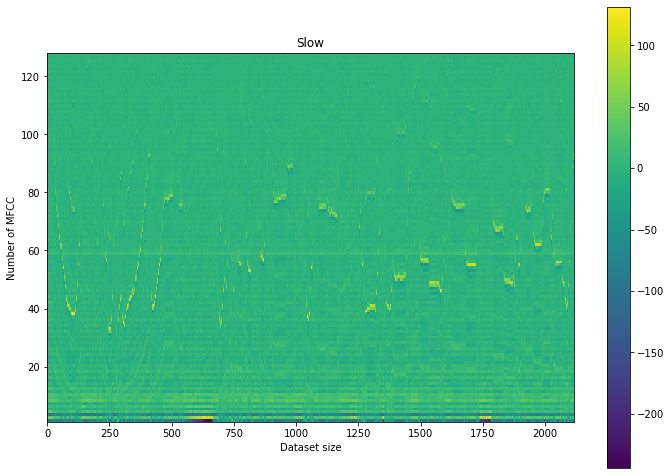

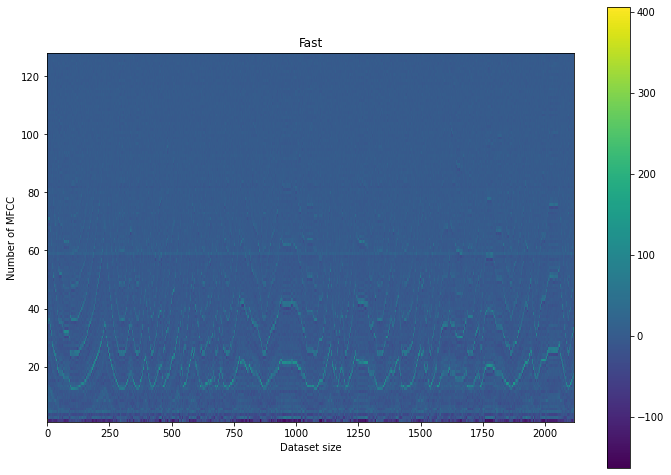

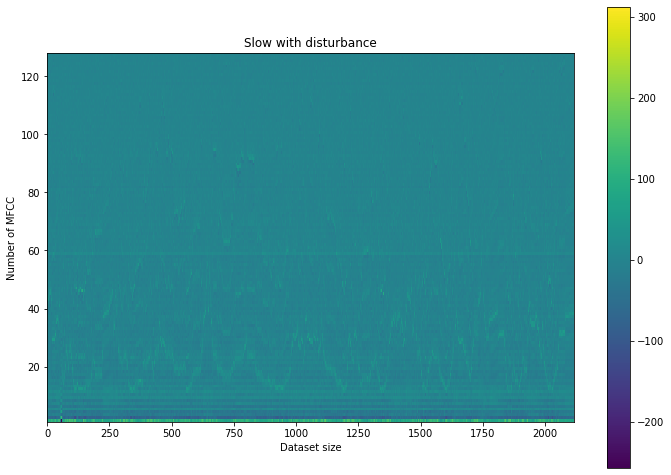

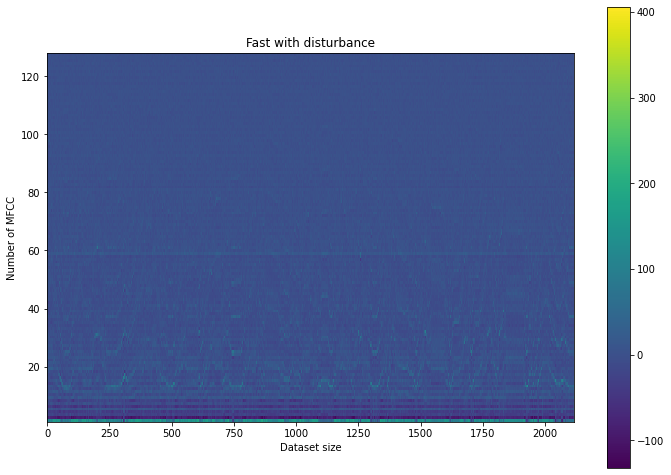

In [5]:
show_spectrogram(X_S.T,0.7,[0, X_S.shape[0], X_S.shape[1] ,1], title='Slow', x_label ="Dataset size", y_label = "Number of MFCC")
show_spectrogram(X_F.T,0.7,[0, X_S.shape[0], X_S.shape[1] ,1], title='Fast', x_label ="Dataset size", y_label = "Number of MFCC")
show_spectrogram(X_SD.T,0.7,[0, X_S.shape[0], X_S.shape[1] ,1], title='Slow with disturbance', x_label ="Dataset size", y_label = "Number of MFCC")
show_spectrogram(X_FD.T,0.7,[0, X_S.shape[0], X_S.shape[1] ,1], title='Fast with disturbance', x_label ="Dataset size", y_label = "Number of MFCC")

In [6]:
X = np.concatenate((X_S,X_F,X_SD,X_FD),axis=0)

y_S = np.ones(len(X_S))*0
y_F = np.ones(len(X_F))*1
y_SD = np.ones(len(X_SD))*2
y_FD = np.ones(len(X_FD))*3

y = np.concatenate((y_S,y_F,y_SD,y_FD))
# Data randomization
idx = np.random.permutation(len(X))
X = X[idx]
y=y[idx]

# Binarization of categorical labels
# From a single vector containing the class number from 0 to 4 
# To a matrix of dimension len(y) and 4 columns cotaining 0 or 1 based for each label
lb = preprocessing.LabelBinarizer()
lb.fit(y)
y=lb.transform(y)

# train/test split
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=1)
trainX, validationX, trainY, validationY = train_test_split(trainX, trainY, test_size=0.25, random_state=1)


model = tf.keras.models.Sequential([ 
    tf.keras.layers.InputLayer(input_shape = (trainX.shape[1])),
    tf.keras.layers.Dense( 56 , activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.001)),
    tf.keras.layers.Dense( 56 , activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dense( len(CLASSES), activation = 'softmax')
    ])

# the user can change the learning rate and the batch size
learningRate = 1e-4
batchSize = 128

_, score = evaluate_model(trainX, trainY ,
                                    validationX, validationY, 
                                    testX, testY, 
                                    model,
                                    learningRate = learningRate,
                                    batchSize = batchSize,
                                    verbosity = 1,
                                    ConfusionMatrix=True,
                                    learning_curves=True)


save_model(model, 'mfcc')

2022-06-24 16:50:36.522297: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-24 16:50:36.523935: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Train on 5080 samples, validate on 1694 samples
Epoch 1/5000
5080/5080 [==============================] - 1s 182us/sample - loss: 15.4669 - acc: 0.2770 - val_loss: 11.0118 - val_acc: 0.3347
Epoch 2/5000
5080/5080 [==============================] - 0s 43us/sample - loss: 8.8782 - acc: 0.3878 - val_loss: 7.2808 - val_acc: 0.5112
Epoch 3/5000
5080/5080 [==============================] - 0s 44us/sample - loss: 6.8248 - acc: 0.5439 - val_loss: 6.3222 - val_acc: 0.6116
Epoch 4/5000
5080/5080 [==============================] - 0s 47us/sample - loss: 6.0753 - acc: 0.6280 - val_loss: 5.7699 - val_acc: 0.6694
Epoch 5/5000
5080/5080 [==============================] - 0s 41us/sample - loss: 5.6135 - acc: 0.6888 - val_loss: 5.4059 - val_acc: 0.7166
Epoch 6/5000
5080/5080 [==============================] - 0s 41us/sample - loss: 5.3008 - acc: 0.7295 - val_loss: 5.1642 - val_acc: 0.7586
Epoch 7/5000
5080/5080 [==============================] - 0s 43us/sample - loss: 5.0709 - acc: 0.7681 - val_loss: 4

KeyboardInterrupt: 